In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive and feel about their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner.

## Data Understanding:
The data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions). From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th).

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys, string, re, itertools, more_itertools, random
from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.base import clone
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (StratifiedKFold, train_test_split,
                                     cross_val_score, GridSearchCV)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer,
                                             TfidfTransformer)
from sklearn.metrics import (f1_score, recall_score, precision_score,
                             make_scorer, plot_confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

import matplotlib.pyplot as plt
# from matplotlib import cm
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

from src import visualizations as vz
from src import functions as fn
from src import classes as cl                                     

# # updates for nltk helper packages if needed
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
                                     
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Modeling I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = path = os.path.join(gparent, 'data/processed',\
                           'modeling_ternary.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        8908 non-null   int64 
 1   stems          8908 non-null   object
 2   lemmas         8908 non-null   object
 3   tweet          8908 non-null   object
 4   brand_product  3271 non-null   object
 5   hashtags       8899 non-null   object
dtypes: int64(1), object(5)
memory usage: 417.7+ KB


In [6]:
df[df.lemmas.isna()]
df[df.lemmas.isna()]

,emotion,stems,lemmas,tweet,brand_product,hashtags


## EDA & Corpus Statistics 

In [7]:
df.emotion.value_counts(normalize=True)

2    0.602941
0    0.333184
1    0.063875
Name: emotion, dtype: float64

## Splitting Emotions

In [8]:
positive = df[df['emotion']==0]
negative = df[df['emotion']==1]
neutral = df[df['emotion']==2]

## Emotion Vocabularies

#### Positive Lemma Vocabulary

In [9]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4631

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [10]:
pos_words = fn.words(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

ipad      		0.0359    
apple     		0.0327    
google    		0.0258    
store     		0.0197    
iphone    		0.0192    
app       		0.014     
new       		0.0126    
austin    		0.0104    
pop       		0.0075    
ipad2     		0.0074    
android   		0.0072    
get       		0.0064    
launch    		0.0061    
party     		0.0053    
one       		0.0053    
line      		0.0051    
great     		0.0048    
time      		0.0048    
via       		0.0046    
day       		0.0044    
free      		0.0044    
social    		0.0044    
circle    		0.0044    
win       		0.0043    
cool      		0.0042    


<font size="4">Fill</font> 

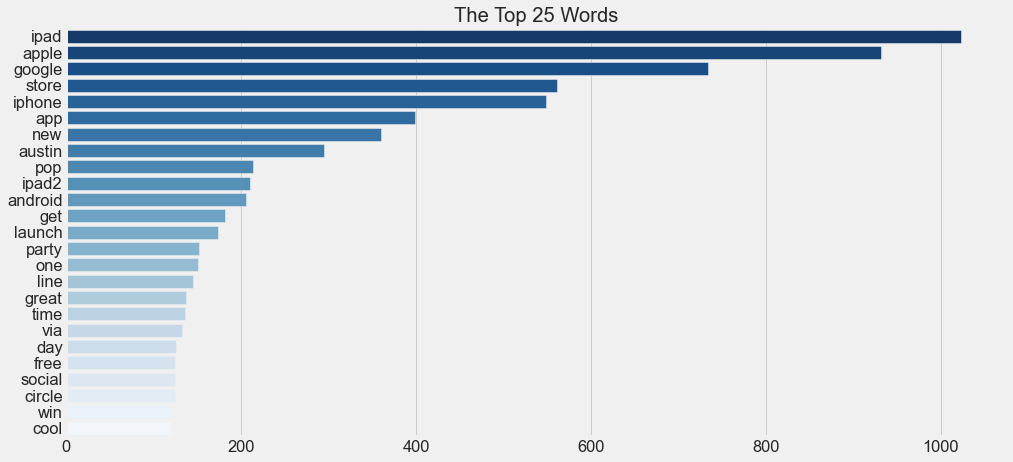

In [11]:
vz.top_word_list(pos_words, 25)

<font size="4">Fill</font>

#### Negative Lemmas Vocabulary

In [12]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

1921

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [13]:
neg_words = fn.words(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

ipad      		0.0344    
iphone    		0.0286    
google    		0.0266    
apple     		0.0217    
app       		0.0106    
store     		0.0083    
new       		0.0076    
like      		0.0076    
circle    		0.0065    
need      		0.0062    
social    		0.0055    
apps      		0.0053    
design    		0.0051    
people    		0.0051    
austin    		0.0049    
get       		0.0044    
android   		0.0042    
one       		0.0041    
think     		0.0041    
time      		0.0041    
line      		0.0039    
launch    		0.0039    
day       		0.0039    
today     		0.0037    
look      		0.0037    


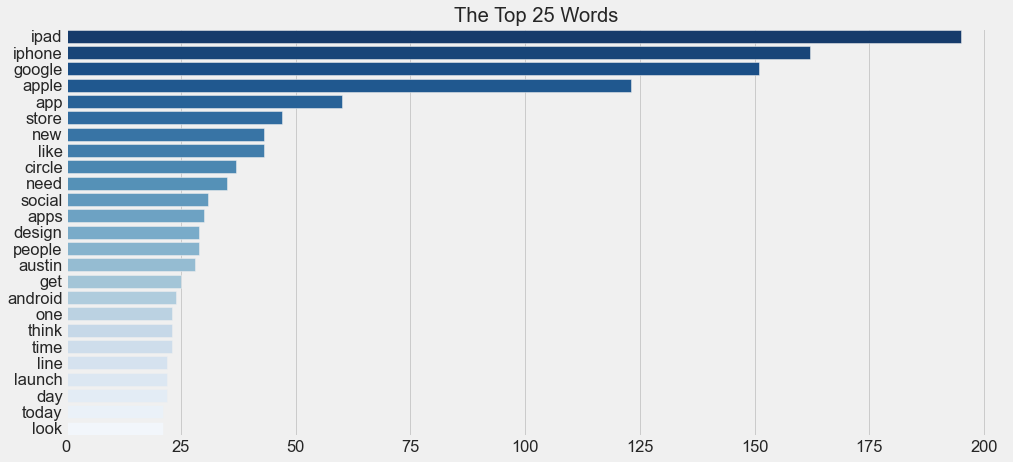

In [14]:
vz.top_word_list(neg_words, 25)

<font size="4">FILL.</font> 

#### Neutral Lemmas Vocabulary

In [15]:
vocab_lem_neu = fn.vocabulary(neutral.lemmas)
len(vocab_lem_pos)

4631

In [16]:
neu_words = fn.words(neutral.lemmas)
fn.word_frequencies(neu_words, 25)

Word 			Frequency

google    		0.0343    
ipad      		0.0252    
apple     		0.0249    
store     		0.018     
iphone    		0.0169    
new       		0.0135    
austin    		0.0127    
circle    		0.0101    
social    		0.0099    
launch    		0.0096    
today     		0.0087    
app       		0.0072    
android   		0.0072    
pop       		0.0072    
network   		0.007     
via       		0.0056    
line      		0.0055    
called    		0.0054    
free      		0.0052    
get       		0.0049    
party     		0.0048    
ipad2     		0.0047    
mobile    		0.0047    
major     		0.0045    
possibly  		0.0037    


## Word Clouds

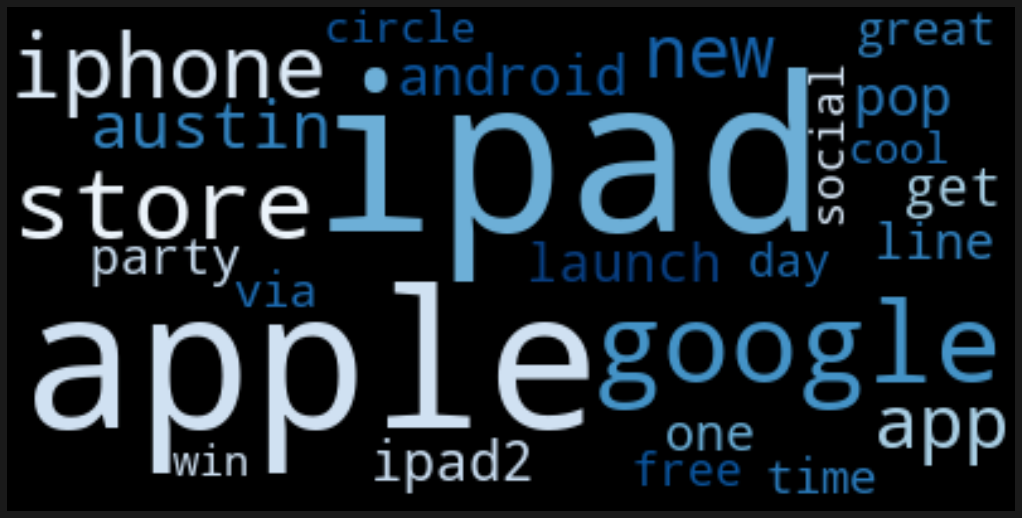

In [17]:
vz.word_cloud(pos_words, 25)

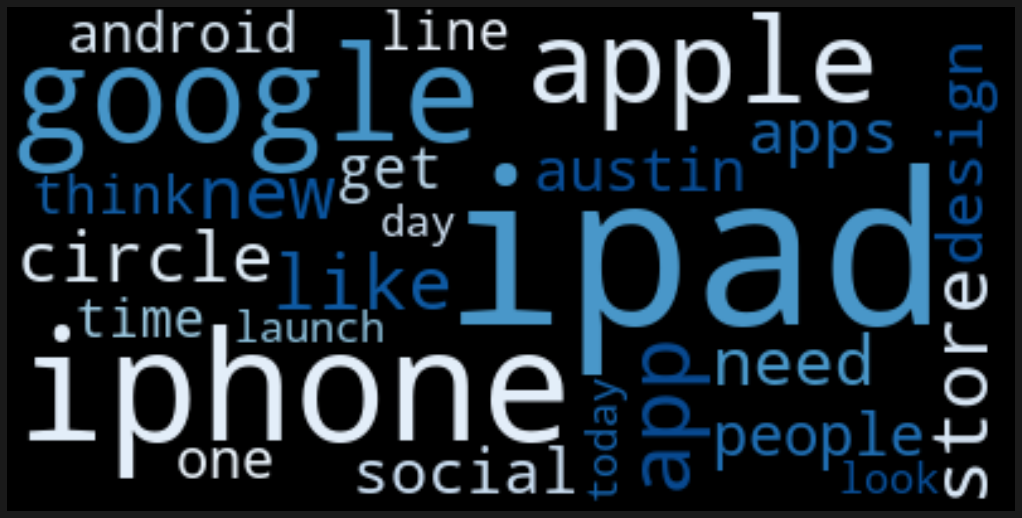

In [18]:
vz.word_cloud(neg_words, 25)

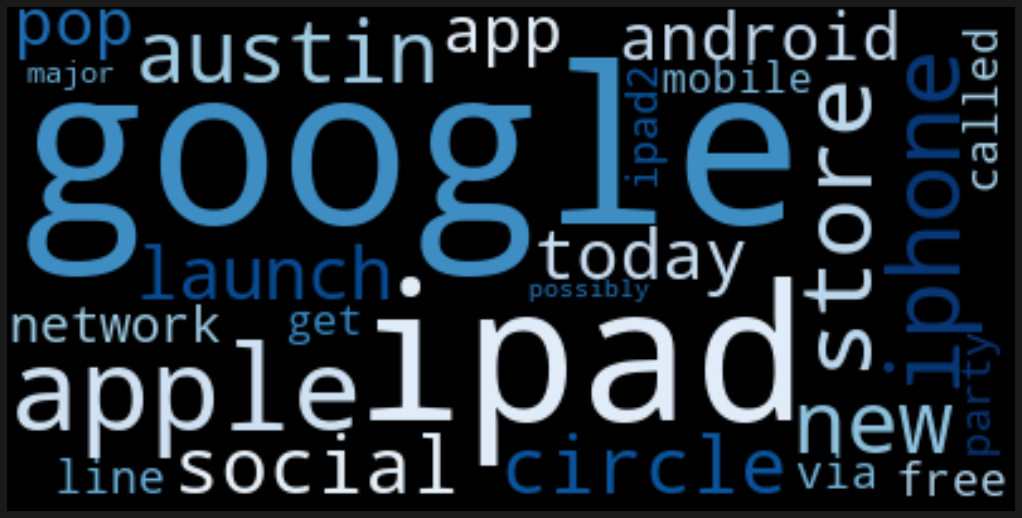

In [19]:
vz.word_cloud(neu_words, 25)

## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [20]:
# filtering
binary_data = df[(df['emotion'] == 0) |\
                 (df['emotion'] == 1)].copy()

In [21]:
# resetting the index
binary_data.reset_index(drop=True, inplace=True)

In [22]:
# checking the first five rows
binary_data.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


In [23]:
# checking the info
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


In [24]:
# checking for nulls
binary_data.isna().sum()

emotion            0
stems              0
lemmas             0
tweet              0
brand_product    357
hashtags           6
dtype: int64

In [25]:
# checking the value counts
binary_data['emotion'].value_counts()

0    2968
1     569
Name: emotion, dtype: int64

In [193]:
binary_data['emotion'].value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [26]:
data_lemms = binary_data.lemmas
data_stems = binary_data.stems
target = binary_data['emotion']

In [27]:
data_lemms.isna().sum()
data_stems.isna().sum()

0

In [28]:
target.isna().sum()

0

In [29]:
# checking lengths
idx = [data_lemms, data_stems, target]
for i in idx:
    print(f'{len(i)}')

3537
3537
3537


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

In [30]:
# Creating data & target
X_lem = data_lemms
y_lem = target

In [31]:
# checking lengths
print(len(X_lem))
print(len(y_lem))

3537
3537


<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [32]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem, y_lem)

In [33]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

2652
2652
885
885


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [34]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training, y_lem_training)

In [35]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

1989
1989
663
663


#### Stemmed Data

In [36]:
X_stem = data_stems
y_stem = target

In [37]:
# checking lengths
print(len(X_stem))
print(len(y_stem))

3537
3537


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [38]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem, y_stem)

In [39]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

2652
2652
885
885


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [40]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training, y_stem_training)

In [41]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

1989
1989
663
663


In [42]:
len(X_stem) == len(y_stem)

True

## Modeling Objects

In [43]:
# creating f1 scorer
f1 = fn.f1

# creating Harness
modeling = cl.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer()

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Creating a Basline Classifier

In [44]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [45]:
steps = [('tfidf', tfidf), ('clf', LR)]
baseline = Pipeline(steps=steps)

In [46]:
baseline.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [47]:
modeling.report(baseline, X_lem_train, y_lem_train, 'LR baseline', 'tfidf/no ngrams, no sampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR baseline has an average F1 of 0.06497737556561087


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.        , 0.08823529, 0.11764706, 0.03076923, 0.08823529])

In [48]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"


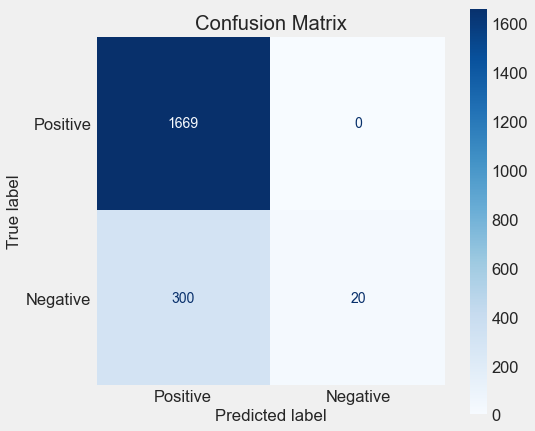

,F1,Recall,Precision
0,0.117647,0.0625,1.0


In [49]:
fn.confusion_report(baseline, X_lem_train, y_lem_train)

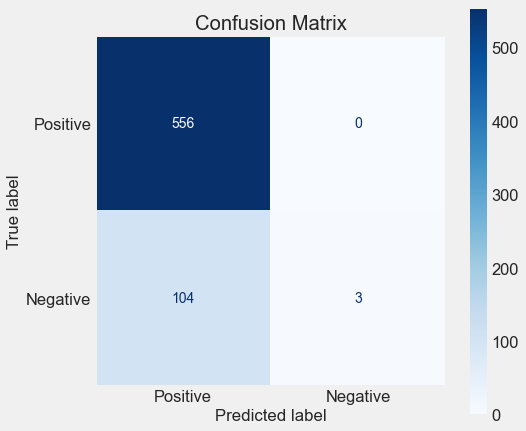

,F1,Recall,Precision
0,0.054545,0.028037,1.0


In [50]:
fn.confusion_report(baseline, X_lem_val, y_lem_val)

## Baseline Minority Oversampling

In [51]:
target.value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

In [52]:
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', LR)]
baseline_mo = Pipeline(steps=steps)

In [53]:
baseline_mo.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [54]:
modeling.report(baseline_mo, X_lem_train, y_lem_train, 'baseline_mo', 'minority oversampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


baseline_mo has an average F1 of 0.4785394764165153


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.47457627, 0.51612903, 0.46031746, 0.453125  , 0.48854962])

In [55]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline_mo,0.478539,minority oversampling


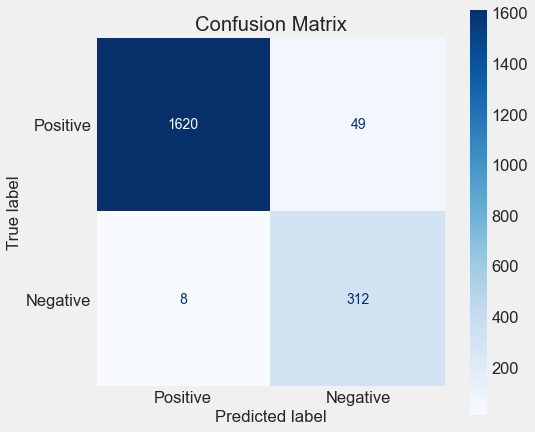

,F1,Recall,Precision
0,0.9163,0.975,0.864266


In [56]:
fn.confusion_report(baseline_mo, X_lem_train, y_lem_train)

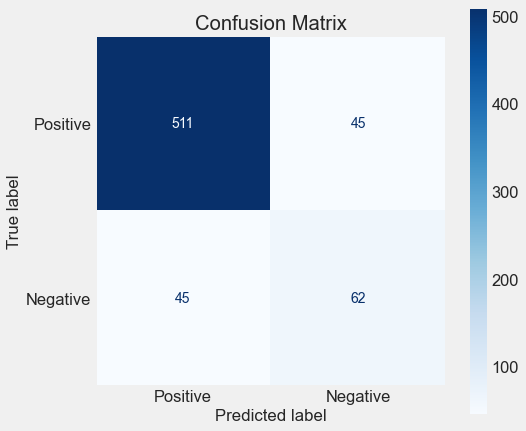

,F1,Recall,Precision
0,0.579439,0.579439,0.579439


In [57]:
fn.confusion_report(baseline_mo, X_lem_val, y_lem_val)

## Baseline Minority Oversampling GridSearch

In [58]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [59]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [60]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [61]:
# grid_clf_f1 = GridSearchCV(baseline_mo, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [62]:
# print('Best ngram_range:', grid_clf_f1.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf_f1.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['clf__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['clf__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['clf__solver'])

In [63]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [64]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  LogisticRegression(C=1.2742749857031321, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [65]:
tuned_baseline_mo = Pipeline(steps=saved_steps)
tuned_baseline_mo.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(C=1.2742749857031321, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [66]:
modeling.report(tuned_baseline_mo, X_lem_train, y_lem_train, 'tuned_baseline_mo', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect 

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_mo has an average F1 of 0.47487741088492125


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.45217391, 0.52892562, 0.4516129 , 0.453125  , 0.48854962])

In [67]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
2,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
1,baseline_mo,0.478539,minority oversampling


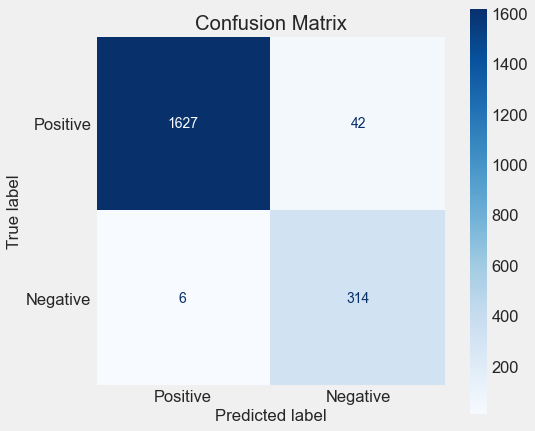

,F1,Recall,Precision
0,0.928994,0.98125,0.882022


In [68]:
fn.confusion_report(tuned_baseline_mo, X_lem_train, y_lem_train)

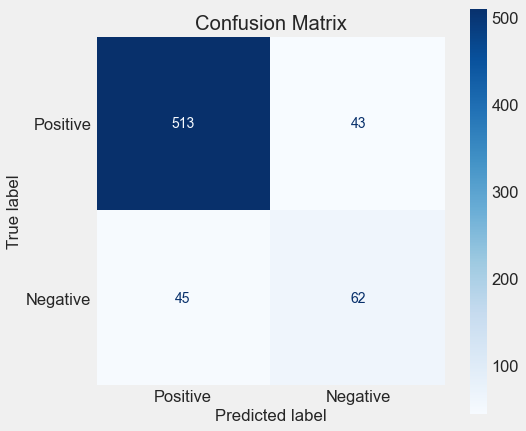

,F1,Recall,Precision
0,0.584906,0.579439,0.590476


In [69]:
fn.confusion_report(tuned_baseline_mo, X_lem_val, y_lem_val)

## Baseline SMOTE 

In [70]:
steps = [('tfidf', tfidf), ('oversample', sm), ('clf', LR)]
baseline_smote = Pipeline(steps=steps)

In [71]:
baseline_smote.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [72]:
modeling.report(baseline_smote, X_lem_train, y_lem_train, 'baseline smote', 'smote')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


baseline smote has an average F1 of 0.44935430052280917


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.45045045, 0.53333333, 0.40310078, 0.40875912, 0.45112782])

In [73]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
3,baseline smote,0.449354,smote
1,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,baseline_mo,0.478539,minority oversampling


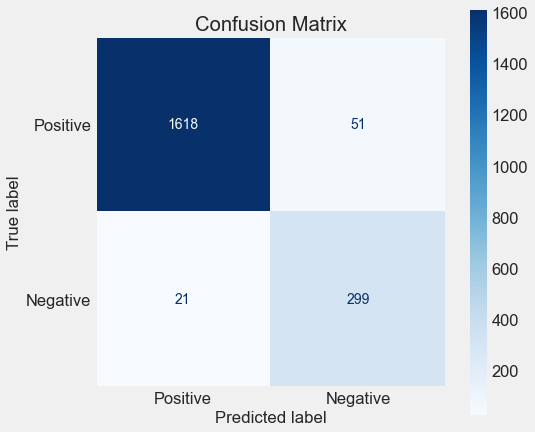

,F1,Recall,Precision
0,0.892537,0.934375,0.854286


In [74]:
fn.confusion_report(baseline_smote, X_lem_train, y_lem_train)

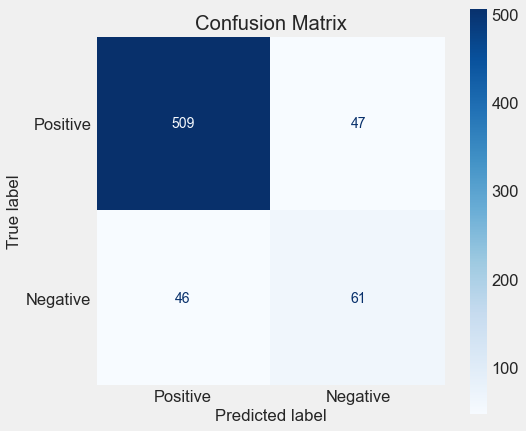

,F1,Recall,Precision
0,0.567442,0.570093,0.564815


In [75]:
fn.confusion_report(baseline_smote, X_lem_val, y_lem_val)

## Baseline SMOTE GridSearch

In [76]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }


In [77]:
# grid_clf = GridSearchCV(baseline_smote, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [78]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best C:', grid_clf.best_estimator_.get_params()['clf__C'])
# print('Best penalty:', grid_clf.best_estimator_.get_params()['clf__penalty'])
# print('Best solver:', grid_clf.best_estimator_.get_params()['clf__solver'])

In [79]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [80]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample', SMOTE(random_state=2021)),
 ('clf',
  LogisticRegression(C=5.455594781168514, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [81]:
tuned_baseline_smote = Pipeline(steps=saved_steps)
tuned_baseline_smote.fit( X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(C=5.455594781168514, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [82]:
modeling.report(tuned_baseline_smote, X_lem_train, y_lem_train, 'tuned_baseline_smote', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear]tuned_baseline_smote has an average F1 of 0.4520495454914407


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.42592593, 0.51327434, 0.4137931 , 0.44444444, 0.46280992])

In [83]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline_mo,0.478539,minority oversampling


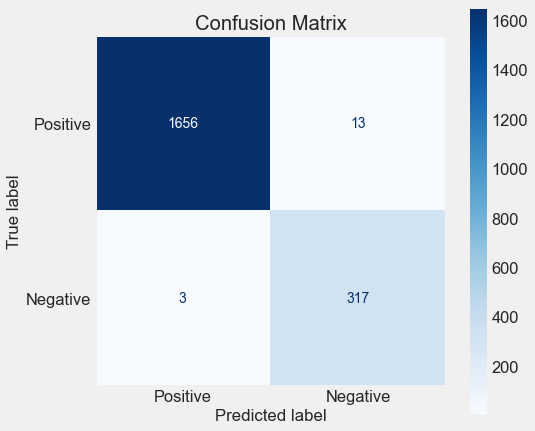

,F1,Recall,Precision
0,0.975385,0.990625,0.960606


In [84]:
fn.confusion_report(tuned_baseline_smote, X_lem_train, y_lem_train)

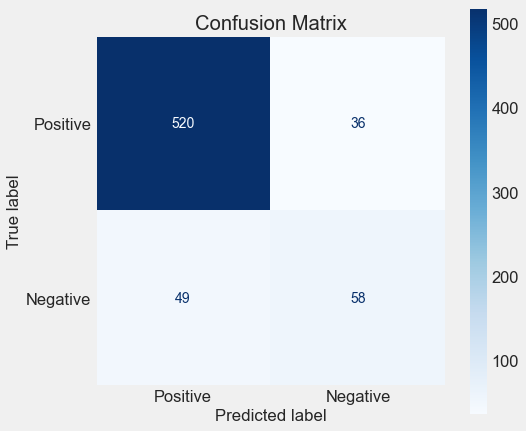

,F1,Recall,Precision
0,0.577114,0.542056,0.617021


In [85]:
fn.confusion_report(tuned_baseline_smote, X_lem_val, y_lem_val)

## Naive Bayes

In [86]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB())])

In [87]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes', 'minority oversamp')

multibayes has an average F1 of 0.4768421787959487


array([0.47222222, 0.46376812, 0.46753247, 0.47435897, 0.50632911])

In [88]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline smote,0.449354,smote
2,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,multibayes,0.476842,minority oversamp
4,baseline_mo,0.478539,minority oversampling


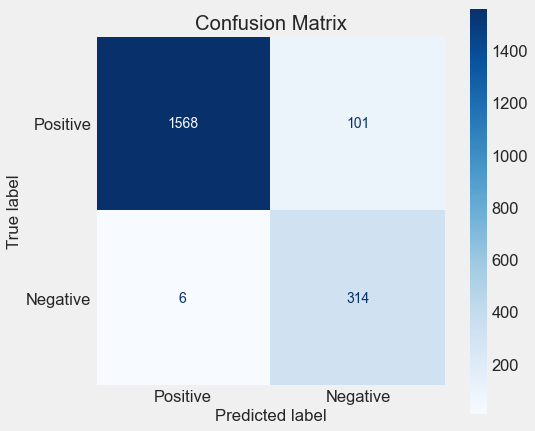

,F1,Recall,Precision
0,0.854422,0.98125,0.756627


In [89]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

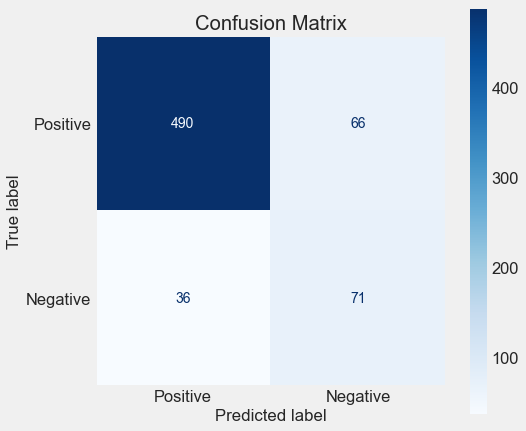

,F1,Recall,Precision
0,0.581967,0.663551,0.518248


In [90]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Naive Bayes

In [91]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [92]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, 25, .5, .75, 1],
    'clf__class_prior': [None, [.16, .84]],
    'clf__fit_prior': [True, False]
    }


In [93]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [94]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best clf__alpha:', grid_clf.best_estimator_.get_params()['clf__alpha'])
# print('Best clf__class_prior:', grid_clf.best_estimator_.get_params()['clf__class_prior'])
# print('Best clf__fit_prior:', grid_clf.best_estimator_.get_params()['clf__fit_prior'])

In [95]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [96]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf', MultinomialNB(alpha=0.5))]

In [97]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB(alpha=0.5))])

In [98]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_multibayes', f'{steps}')

tuned_multibayes has an average F1 of 0.48974305843348526


array([0.5       , 0.48818898, 0.46666667, 0.46052632, 0.53333333])

In [99]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline smote,0.449354,smote
2,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,multibayes,0.476842,minority oversamp
5,baseline_mo,0.478539,minority oversampling
6,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."


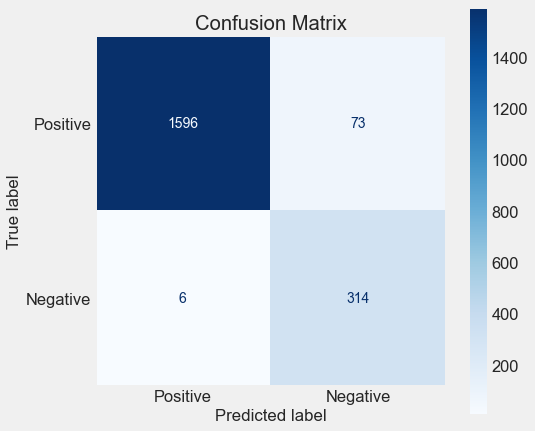

,F1,Recall,Precision
0,0.88826,0.98125,0.81137


In [100]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

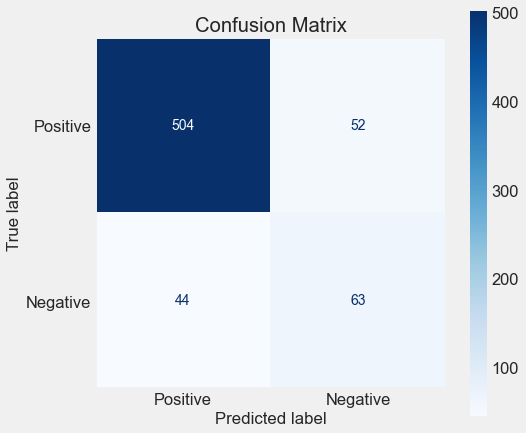

,F1,Recall,Precision
0,0.567568,0.588785,0.547826


In [101]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest

In [102]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', RF)]
rf_pipe = Pipeline(steps=steps)
rf_pipe.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [103]:
modeling.report(rf_pipe, X_lem_train, y_lem_train, 'rf_mo', 'default random forest')

rf_mo has an average F1 of 0.37452137083287795


array([0.43678161, 0.30769231, 0.37777778, 0.35955056, 0.3908046 ])

In [104]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
7,rf_mo,0.374521,default random forest
1,baseline smote,0.449354,smote
2,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,multibayes,0.476842,minority oversamp
5,baseline_mo,0.478539,minority oversampling
6,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."


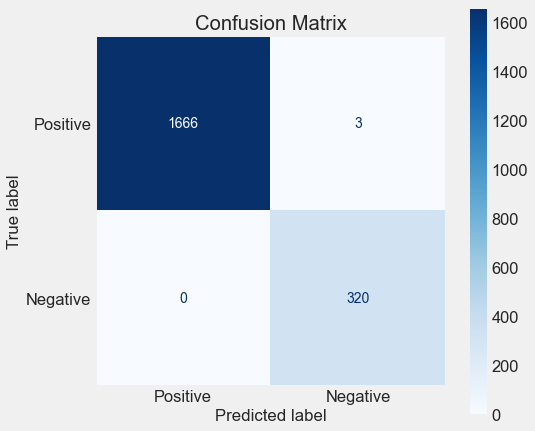

,F1,Recall,Precision
0,0.995334,1.0,0.990712


In [105]:
fn.confusion_report(rf_pipe, X_lem_train, y_lem_train)

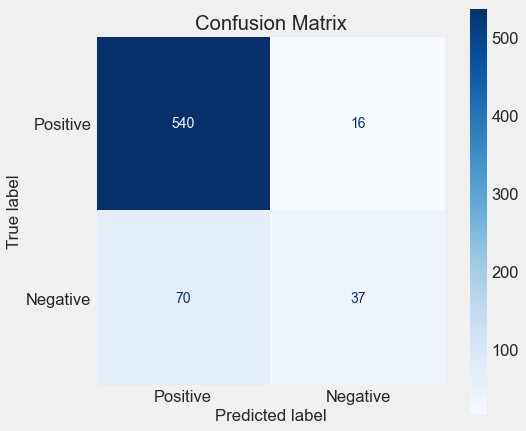

,F1,Recall,Precision
0,0.4625,0.345794,0.698113


In [106]:
fn.confusion_report(rf_pipe, X_lem_val, y_lem_val)

## Tuned Random Forest

In [107]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [108]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [109]:
# grid_clf = GridSearchCV(rf_pipe, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [110]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best clf__criterion:', grid_clf.best_estimator_.get_params()['clf__criterion'])
# print('Best clf__min_samples_split:', grid_clf.best_estimator_.get_params()['clf__min_samples_split'])
# print('Best clf__max_features:', grid_clf.best_estimator_.get_params()['clf__max_features'])
# print('Best clf__min_samples_leaf:', grid_clf.best_estimator_.get_params()['clf__min_samples_leaf'])

In [111]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [112]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  RandomForestClassifier(max_features=None, min_samples_split=10, n_estimators=50,
                         n_jobs=-1, random_state=2021))]

In [113]:
tuned_rf = Pipeline(steps=saved_steps)
tuned_rf.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 RandomForestClassifier(max_features=None, min_samples_split=10,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=2021))])

In [114]:
modeling.report(tuned_rf, X_lem_train, y_lem_train, 'tuned_rf', f'{steps}')

tuned_rf has an average F1 of 0.43596769692227433


array([0.448     , 0.4       , 0.45070423, 0.421875  , 0.45925926])

In [115]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
8,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,baseline smote,0.449354,smote
3,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,multibayes,0.476842,minority oversamp
6,baseline_mo,0.478539,minority oversampling
7,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."


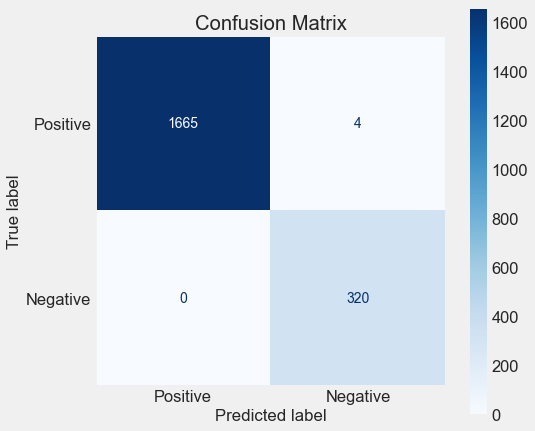

,F1,Recall,Precision
0,0.993789,1.0,0.987654


In [116]:
fn.confusion_report(tuned_rf, X_lem_train, y_lem_train)

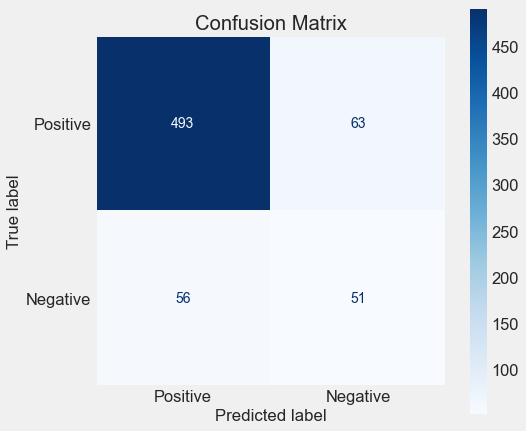

,F1,Recall,Precision
0,0.461538,0.476636,0.447368


In [117]:
fn.confusion_report(tuned_rf, X_lem_val, y_lem_val)

## Importing Augmented Data

In [118]:
path = os.path.join(gparent, 'data/processed', 'augmented_data.csv')
augmented = pd.read_csv(path, encoding='unicode_escape')

## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [119]:
# filtering
binary_augmented = augmented[(augmented['emotion'] == 0) |\
                 (augmented['emotion'] == 1)].copy()

In [120]:
# resetting the index
binary_augmented.reset_index(drop=True, inplace=True)

In [121]:
# checking the first five rows
binary_augmented.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


In [122]:
# checking the info
binary_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        5871 non-null   int64 
 1   stems          5871 non-null   object
 2   lemmas         5871 non-null   object
 3   tweet          5871 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3868 non-null   object
dtypes: int64(1), object(5)
memory usage: 275.3+ KB


In [123]:
# checking for nulls
binary_augmented.isna().sum()

emotion             0
stems               0
lemmas              0
tweet               0
brand_product    2691
hashtags         2003
dtype: int64

In [124]:
# checking the value counts
binary_augmented['emotion'].value_counts()

0    2968
1    2903
Name: emotion, dtype: int64

## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [125]:
aug_lemms = binary_augmented.lemmas
aug_stems = binary_augmented.stems
aug_target = binary_augmented['emotion']

In [126]:
print(aug_lemms.isna().sum())
aug_stems.isna().sum()

0


0

In [127]:
aug_target.isna().sum()

0

In [128]:
# checking lengths
idx = [aug_lemms, aug_stems, aug_target]
for i in idx:
    print(f'{len(i)}')

5871
5871
5871


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

In [129]:
# Creating data & target
X_lem = aug_lemms
y_lem = aug_target

In [130]:
# checking lengths
print(len(X_lem))
print(len(y_lem))

5871
5871


<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [131]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem, y_lem)

In [132]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [133]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training, y_lem_training)

In [134]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

3302
3302
1101
1101


#### Stemmed Data

In [135]:
X_stem = aug_stems
y_stem = aug_target

In [136]:
# checking lengths
print(len(X_stem))
print(len(y_stem))

5871
5871


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [137]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem, y_stem)

In [138]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [139]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training, y_stem_training)

In [140]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

3302
3302
1101
1101


In [141]:
len(X_stem) == len(y_stem)

True

## Basline Classifier on Augmented Data

In [142]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [143]:
steps = [('tfidf', tfidf), ('clf', LR)]
baseline = Pipeline(steps=steps)

In [144]:
baseline.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [145]:
modeling.report(baseline, X_lem_train, y_lem_train, 'baseline_aug', 'augmented data')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


baseline_aug has an average F1 of 0.8904233343568576


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.88498403, 0.89245586, 0.89869281, 0.89105691, 0.88492707])

In [146]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
2,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.476842,minority oversamp
7,baseline_mo,0.478539,minority oversampling
8,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
9,baseline_aug,0.890423,augmented data


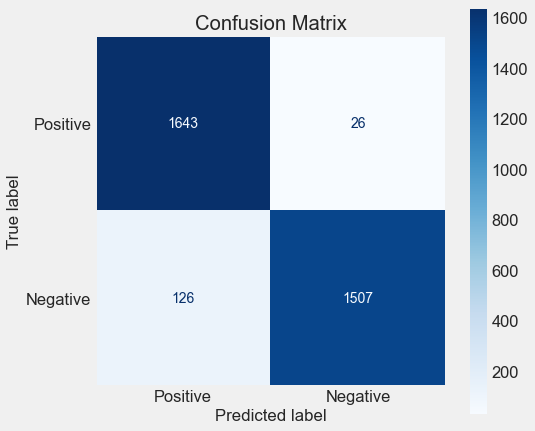

,F1,Recall,Precision
0,0.95199,0.922841,0.98304


In [147]:
fn.confusion_report(baseline, X_lem_train, y_lem_train)

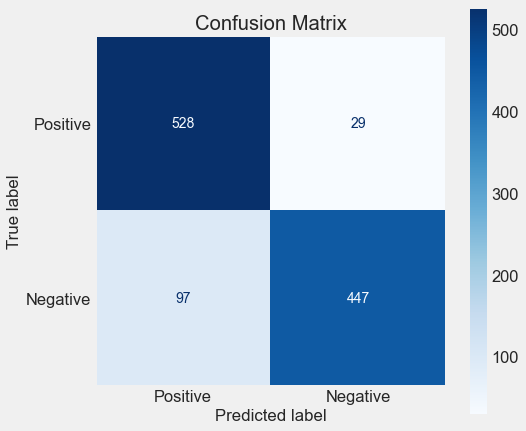

,F1,Recall,Precision
0,0.876471,0.821691,0.939076


In [148]:
fn.confusion_report(baseline, X_lem_val, y_lem_val)

## Tuned Baseline

In [149]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [150]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [151]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [152]:
# grid_clf_f1 = GridSearchCV(baseline, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [153]:
# print('Best ngram_range:', grid_clf_f1.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf_f1.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['clf__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['clf__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['clf__solver'])

In [154]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [155]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
 ('clf',
  LogisticRegression(C=11.288378916846883, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [156]:
tuned_baseline = Pipeline(steps=saved_steps)
tuned_baseline.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [157]:
modeling.report(tuned_baseline, X_lem_train, y_lem_train, 'tuned_baseline_aug', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_aug has an average F1 of 0.896377949045436


array([0.89108911, 0.90113452, 0.89768977, 0.89621087, 0.89576547])

In [158]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
2,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.476842,minority oversamp
7,baseline_mo,0.478539,minority oversampling
8,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
9,baseline_aug,0.890423,augmented data


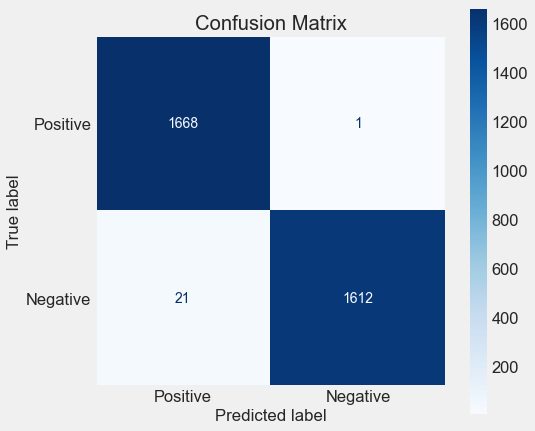

,F1,Recall,Precision
0,0.993222,0.98714,0.99938


In [159]:
fn.confusion_report(tuned_baseline, X_lem_train, y_lem_train)

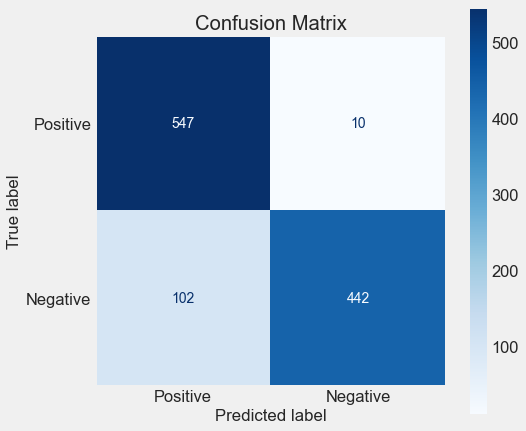

,F1,Recall,Precision
0,0.88755,0.8125,0.977876


In [160]:
fn.confusion_report(tuned_baseline, X_lem_val, y_lem_val)

## Naive Bayes

In [161]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [162]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes_aug', 'augmented_data')

multibayes_aug has an average F1 of 0.8589519418868138


array([0.85245902, 0.87086093, 0.86333333, 0.86634461, 0.84176183])

In [163]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
2,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.476842,minority oversamp
7,baseline_mo,0.478539,minority oversampling
8,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
11,multibayes_aug,0.858952,augmented_data


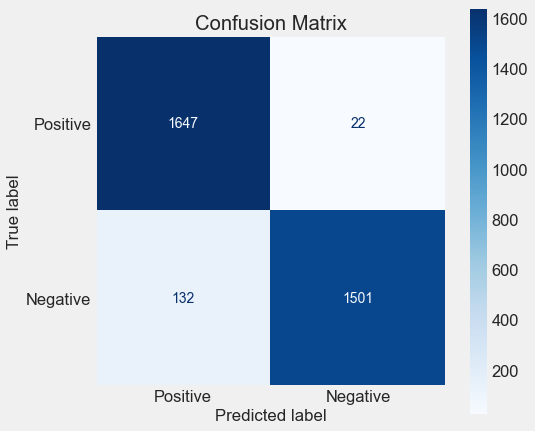

,F1,Recall,Precision
0,0.951204,0.919167,0.985555


In [164]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

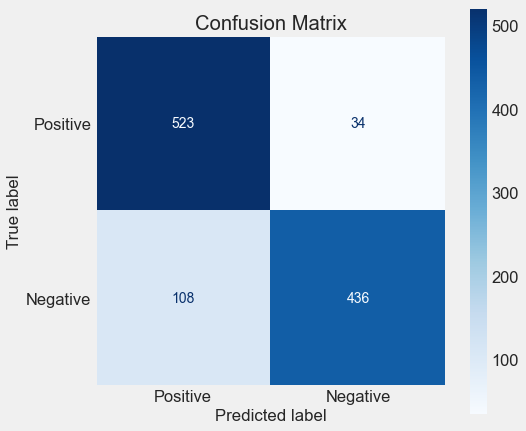

,F1,Recall,Precision
0,0.859961,0.801471,0.92766


In [165]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Naive Bayes

In [166]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [167]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, .25, .5, .75, 1],
    'clf__fit_prior': [True, False]
    }


In [168]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [169]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best clf__alpha:', grid_clf.best_estimator_.get_params()['clf__alpha'])
# print('Best clf__class_prior:', grid_clf.best_estimator_.get_params()['clf__class_prior'])
# print('Best clf__fit_prior:', grid_clf.best_estimator_.get_params()['clf__fit_prior'])

In [170]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [171]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 5), use_idf=False)),
 ('clf', MultinomialNB(alpha=0.25, fit_prior=False))]

In [172]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 5), use_idf=False)),
                ('clf', MultinomialNB(alpha=0.25, fit_prior=False))])

In [173]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_mnb_aug', f'{steps}')

tuned_mnb_aug has an average F1 of 0.8735455234135003


array([0.86468647, 0.8830313 , 0.88146912, 0.87725041, 0.86129032])

In [174]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
2,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.476842,minority oversamp
7,baseline_mo,0.478539,minority oversampling
8,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
9,multibayes_aug,0.858952,augmented_data


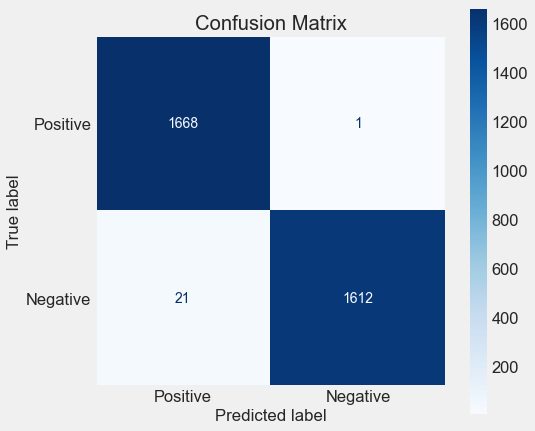

,F1,Recall,Precision
0,0.993222,0.98714,0.99938


In [175]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

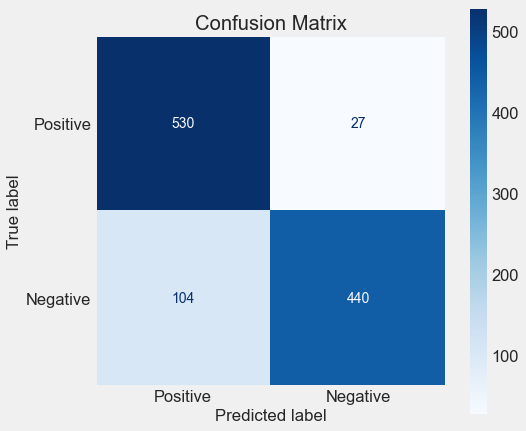

,F1,Recall,Precision
0,0.870425,0.808824,0.942184


In [176]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest on Augmented Data

In [177]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('clf', RF)]
rf_aug = Pipeline(steps=steps)
rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [178]:
modeling.report(rf_aug, X_lem_train, y_lem_train, 'rf_aug', 'augmented data')

rf_aug has an average F1 of 0.8966883615884242


array([0.89326765, 0.90131579, 0.89250814, 0.90196078, 0.89438944])

In [179]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
2,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.476842,minority oversamp
7,baseline_mo,0.478539,minority oversampling
8,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
9,multibayes_aug,0.858952,augmented_data


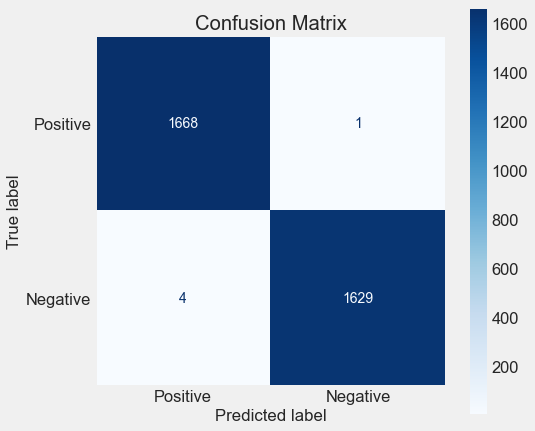

,F1,Recall,Precision
0,0.998468,0.997551,0.999387


In [181]:
fn.confusion_report(rf_aug, X_lem_train, y_lem_train)

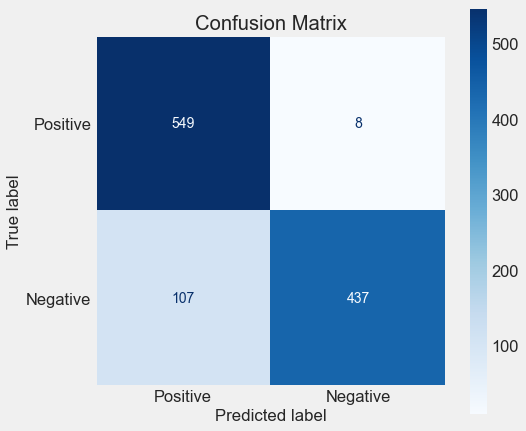

,F1,Recall,Precision
0,0.883721,0.803309,0.982022


In [182]:
fn.confusion_report(rf_aug, X_lem_val, y_lem_val)

## Tuned Random Forest

In [107]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [183]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [184]:
# grid_clf = GridSearchCV(rf_aug, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 37.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=2021))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 10, None],
                         'clf__max_features': [None, 'auto'],
                         'clf__min_samples_leaf': [1, 3],
                         'clf__min_samples_split': [2, 10],
                         'clf__n_estimators': [50, 100],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4),
                                                (1, 5)],
                         'tfidf__use_idf': (True, False)},
             scoring='f1', verbose=4)

In [110]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best clf__criterion:', grid_clf.best_estimator_.get_params()['clf__criterion'])
# print('Best clf__min_samples_split:', grid_clf.best_estimator_.get_params()['clf__min_samples_split'])
# print('Best clf__max_features:', grid_clf.best_estimator_.get_params()['clf__max_features'])
# print('Best clf__min_samples_leaf:', grid_clf.best_estimator_.get_params()['clf__min_samples_leaf'])

In [185]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [187]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
 ('clf',
  RandomForestClassifier(min_samples_split=10, n_jobs=-1, random_state=2021))]

In [188]:
tuned_rf = Pipeline(steps=saved_steps)
tuned_rf.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

In [189]:
modeling.report(tuned_rf, X_lem_train, y_lem_train, 'tuned_rf_aug', f'{steps}')

tuned_rf_aug has an average F1 of 0.8923784854925113


array([0.9       , 0.90127389, 0.88038278, 0.88924051, 0.89099526])

In [190]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.374521,default random forest
2,tuned_rf,0.435968,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline smote,0.449354,smote
4,tuned_baseline_smote,0.452050,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.474877,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.476842,minority oversamp
7,baseline_mo,0.478539,minority oversampling
8,tuned_multibayes,0.489743,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
9,multibayes_aug,0.858952,augmented_data


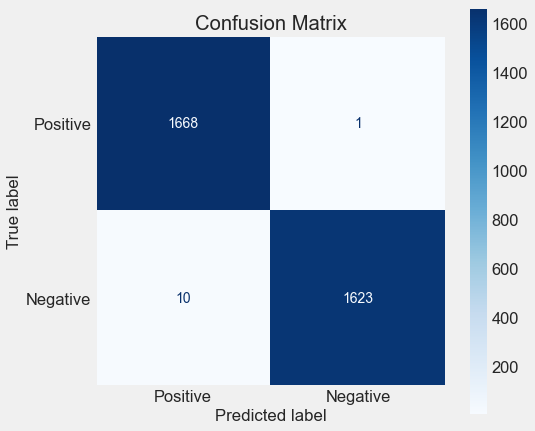

,F1,Recall,Precision
0,0.996623,0.993876,0.999384


In [191]:
fn.confusion_report(tuned_rf, X_lem_train, y_lem_train)

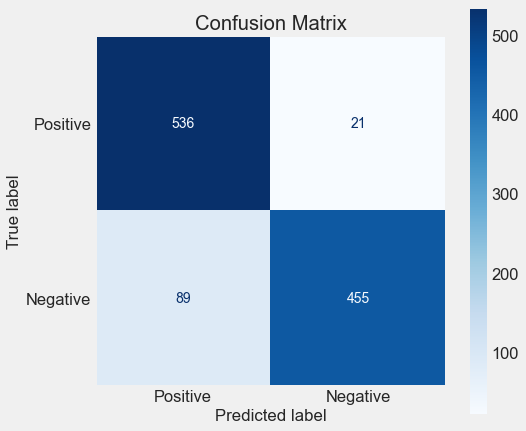

,F1,Recall,Precision
0,0.892157,0.836397,0.955882


In [192]:
fn.confusion_report(tuned_rf, X_lem_val, y_lem_val)